# Homework 06 — IANNwTF
## Group 27
Deadline: Dec 5, 2021 23:59

<https://forms.gle/8qwiuUXCfLjKGeg67>

In [1]:
# libraries
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
%config InlineBackend.figure_format = 'retina'

## Dataset

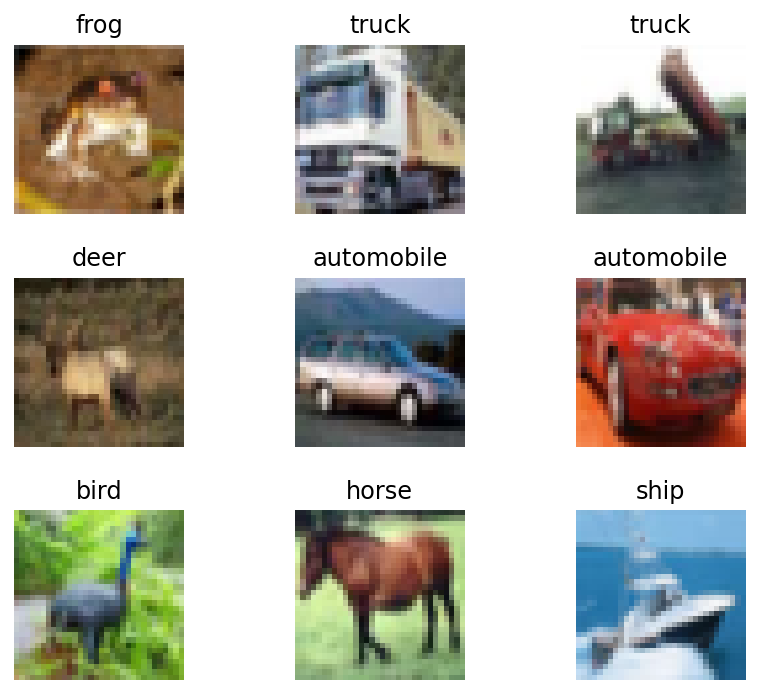

In [2]:
(training_inputs, training_labels), (test_inputs, test_labels) = tf.keras.datasets.cifar10.load_data()

text_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
fig, ax = plt.subplots(3,3, figsize=(6,5))
fig.tight_layout()
ax = ax.flatten()
for i in range(9):
    image = training_inputs[i]
    label = text_labels[training_labels[i][-1]]
    ax[i].imshow(image)
    ax[i].set_title(label)
    ax[i].axis("off")

In [3]:
def prepare_data(ds):
    # normalise images and then one-hot-encode the targets
    ds = ds.map(lambda inputs, targets: ((2*(inputs/255)-1), tf.one_hot(tf.squeeze(targets), 10)))
    # batch, shuffle and prefetch
    ds = ds.batch(batch_size).shuffle(batch_size).prefetch(128)
    return ds

In [4]:
batch_size = 64

# split into training, valid, and test datasets
training_dataset = tf.data.Dataset.from_tensor_slices((training_inputs, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels))

# prepare the datasets
training_dataset = prepare_data(training_dataset)
test_dataset = prepare_data(test_dataset)   

input_shape=(batch_size,32,32,3)
num_classes = 10

## Model
### ResNet

In [5]:
class ResidualBlock(tf.keras.layers.Layer):
    '''
    Constant residual block that doesn't change the number of channels.
    '''
    def __init__(self):
        '''
        Initializes the layers of the residual block.
        '''
        super(ResidualBlock, self).__init__()

        self.batch1 = tf.keras.layers.BatchNormalization() 
        self.act1 = tf.keras.layers.Activation(tf.nn.relu)
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size =(1,1))
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.act2 = tf.keras.layers.Activation(tf.nn.relu)
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size =(3,3), padding="same")
        self.batch3 = tf.keras.layers.BatchNormalization()
        self.act3 = tf.keras.layers.Activation(tf.nn.relu)
        self.conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size =(1,1))

    
    def call(self, x, training = True):
        '''
        Does the computations of the residual block.
        '''
        x_out = self.batch1(x, training)
        x_out = self.act1(x_out)
        x_out = self.conv1(x_out)
        x_out = self.batch2(x_out, training)
        x_out = self.act2(x_out)
        x_out = self.conv2(x_out)
        x_out = self.batch3(x_out, training)
        x_out = self.act3(x_out)
        x_out = self.conv3(x_out)
        return tf.keras.layers.Add()([x_out, x])

Implement a callable ResNet class, consisting of a convolutional layer followed by
multiple Residual Blocks and an output layer. 6
To further explore your networks behaviour, it might be convenient to implement
it in a way that you can easily alter the number of Residual Blocks. 7
Implement the network’s call function. 8

In [6]:
class ResNetModel(tf.keras.Model):
    '''
    Custom ResNetModel using the custom ResidualBlock from before.
    '''
    def __init__(self, **kwargs):
        '''
        Initializes the model.
        '''
        super(ResNetModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size =1)
        self.res1 = ResidualBlock()
        self.res2 = ResidualBlock()
        self.res3 = ResidualBlock()
        self.res4 = ResidualBlock()
        self.res5 = ResidualBlock()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(128,activation='relu')
        self.batch1 = tf.keras.layers.BatchNormalization()
        self.dense2 = tf.keras.layers.Dense(256,activation='relu')
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.dense3 = tf.keras.layers.Dense(512,activation='relu')
        self.batch3 = tf.keras.layers.BatchNormalization()
        self.dense4 = tf.keras.layers.Dense(1024,activation='relu')
        self.batch4 = tf.keras.layers.BatchNormalization()
        self.flatten2 = tf.keras.layers.Flatten()
        self.dense5 = tf.keras.layers.Dense(128,activation='relu')
        self.dense = tf.keras.layers.Dense(num_classes,activation='softmax')
        
    def call(self, inputs, training=False):
        '''
        Performs a forward step in our MLP
          
        Args:
          inputs (Tensor): input to the model
          training (bool): flag for batch normalization layers
          
        Returns: 
          x: output of the model
        '''
        x = self.conv1(inputs)
        x = self.res1(x, training=training)
        x = self.res2(x, training=training)
        x = self.res3(x, training=training)
        x = self.res4(x, training=training)
        x = self.res5(x, training=training)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.batch1(x, training=training)
        x = self.dense2(x) 
        x = self.batch2(x, training=training)
        x = self.dense3(x) 
        x = self.batch3(x, training=training)
        x = self.dense4(x) 
        x = self.batch4(x, training=training)
        x = self.flatten2(x)
        x = self.dense5(x)
        output = self.dense(x)
        return output


### DenseNet

## Training and 📈

In [7]:
@tf.function
def train_step(model, inputs, targets, loss_fn, optimizer, loss_metric, accuracy_metric):
    # training step
    with tf.GradientTape() as tape:
      predictions = model(inputs, training=True)
      loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    logs = {}
    accuracy_metric.update_state(targets, predictions)
    logs[accuracy_metric.name] = accuracy_metric.result()
    loss_metric.update_state(loss)
    logs["loss"] = loss_metric.result()
    return logs
    
@tf.function
def test_step(inputs, targets, loss_fn, loss_metric, accuracy_metric):
    # test step
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)
    logs = {}
    accuracy_metric.update_state(targets, predictions)
    logs["val_" + accuracy_metric.name] = accuracy_metric.result()
    loss_metric.update_state(loss)
    logs["val_loss"] = loss_metric.result()
    return logs

In [ ]:
tf.keras.backend.clear_session()

# hyperparameters
num_epochs = 30
learning_rate = 0.001

# initialize the model
model = ResNetModel()
# initialize the loss function
loss_fn = tf.keras.losses.CategoricalCrossentropy()
# initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate, amsgrad = True)

# Metrics
accuracy_metric = tf.keras.metrics.CategoricalAccuracy()
loss_metric = tf.keras.metrics.Mean()
hist = {'loss': [], 'val_loss': [], 'categorical_accuracy': [], 'val_categorical_accuracy': []}


def reset_metrics(metrics):
    # utility function to reset the state of metrics
    for metric in metrics:
        metric.reset_state()

# training
for epoch in range(num_epochs):
    reset_metrics([accuracy_metric,loss_metric])
    for inputs, targets in training_dataset:
        logs = train_step(model, inputs, targets, loss_fn, optimizer, loss_metric, accuracy_metric)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        hist[key].append(value)
        print(f"...{key}: {value:.4f}")
    
    # test
    reset_metrics([accuracy_metric,loss_metric])
    for (inputs_batch, targets_batch) in test_dataset:
        logs = test_step(inputs_batch, targets_batch, loss_fn, loss_metric, accuracy_metric)   
    print("...Evaluation results:")
    for key, value in logs.items():
        hist[key].append(value)
        print(f"...{key}: {value:.4f}")
    

Results at the end of epoch 0
...categorical_accuracy: 0.4430
...loss: 1.5949
...Evaluation results:
...val_categorical_accuracy: 0.5290
...val_loss: 1.3423
Results at the end of epoch 1
...categorical_accuracy: 0.6136
...loss: 1.0909
...Evaluation results:
...val_categorical_accuracy: 0.6351
...val_loss: 1.0443
Results at the end of epoch 2
...categorical_accuracy: 0.7073
...loss: 0.8258
...Evaluation results:
...val_categorical_accuracy: 0.6752
...val_loss: 0.9252


In [ ]:
plt.rcParams['font.size'] = 15
plt.plot(hist['loss'], label='Training loss')
plt.plot(hist['categorical_accuracy'], label='Train accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(num_epochs + 1, step=2))
plt.legend()
plt.suptitle("Training ResNet")


plt.figure()
plt.suptitle("Testing ResNet")
plt.plot(hist['val_loss'], label='Test loss')
plt.plot(hist['val_categorical_accuracy'], label='Test accuracy')
plt.text(len(hist['val_categorical_accuracy'])-1,
         hist['val_categorical_accuracy'][-1],
         round(hist['val_categorical_accuracy'][-1].numpy(), 2),
         color = 'orange',
         bbox = dict(facecolor = 'white', alpha = 0.95))
plt.xticks(np.arange(num_epochs + 1, step=2))
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
model.summary()